In [13]:
from algames import ALGAMES

import numpy as np
import matplotlib.pyplot as plt

In [14]:
# M players
M = 3

# N horizon length
N = 10

# n state size
n = 4  # (x, y, v_x, v_y)

# m control input size
m = 2  # (a_x, a_y)

# timestep
dt = 0.1

# collision avoidance radius
r = 0.25

# running cost matrix
Q = np.eye(n)

# terminal cost matrix
Qf = np.eye(n) * 100

# control cost matrix
R = np.eye(m)

# penalty gain
rho = 0

# penalty schedule
gamma = 1.1

# convergence tolerance
eps = 10

# max iterations
max_iter = 10

# multiplier to enforce dynamics
dynamics_mult = 1000

In [15]:
# initial state
x1_0 = np.array([0, 0, 2, 0.5])
x2_0 = np.array([0, -0.5, 3, 0])
x3_0 = np.array([0.5, 0.25, 0.5, -2])
list_x0 = [x1_0, x2_0, x3_0]

# final state
x1_f = np.array([1.5, 0, 2, 0])
x2_f = np.array([2, 0, 2, 0])
x3_f = np.array([2.5, 0, 2, 0])
list_xf = [x1_f, x2_f, x3_f]

# constraints
constraint_wall_y = 1
constraint_u_x_max = 10
constraint_u_y_max = constraint_u_x_max

In [16]:
X, U = ALGAMES(
    M,  # number players
    N,  # horizon
    dt,  # timestep
    r,  # collision avoidance radius
    list_x0,  # list of initial states
    list_xf,  # list of target states
    Q,  # running cost matrix
    Qf,  # terminal cost matrix
    R,  # control cost matrix
    rho,  # constraint penalty value
    gamma,  # constraint penalty schedule
    eps,  # convergence tolerance
    constraint_wall_y,  # y value of horizontal wall
    constraint_u_x_max,  # control input x bound
    constraint_u_y_max,  # control input y bound
    max_iter,
    dynamics_mult,
)

606261.4422944741
610307.5245617601
610307.5245617601


In [43]:
print(X.shape)
print(U.shape)
x_players = np.split(X, M)
#print(x_players)
n = 4
M = 3

list_x0 = []
for i, x in enumerate(x_players):
    print(i)
    print(x)
    x1 = x[0:n]
    print(x1)
    list_x0.append(x1)

print(list_x0)
r1 = np.reshape(np.array(list_x0), (M*n))
print(r1)
r2 = np.reshape(r1, (M, n))
print(r2)

(120,)
(60,)
0
[ 1.86900613e-01  3.97012901e-02  1.73908950e+00  2.94772327e-01
  3.50340483e-01  6.10572661e-02  1.53090718e+00  1.33072880e-01
  4.95662672e-01  6.81967666e-02  1.37684740e+00  1.04219785e-02
  6.28377637e-01  6.48401880e-02  1.27886410e+00 -7.68699967e-02
  7.54221860e-01  5.43736270e-02  1.23952413e+00 -1.31799752e-01
  8.79222149e-01  3.99143246e-02  1.26206737e+00 -1.56747908e-01
  1.00939735e+00  2.42909673e-02  1.34309399e+00 -1.55105199e-01
  1.15086921e+00  1.00966031e-02  1.48806249e+00 -1.28193488e-01
  1.31037555e+00 -1.72290365e-04  1.70383602e+00 -7.66221589e-02
  1.49542009e+00 -4.04507149e-03  1.99886836e+00 -2.98239502e-04]
[0.18690061 0.03970129 1.7390895  0.29477233]
1
[ 2.81020041e-01 -4.86430976e-01  2.62132905e+00  2.69930254e-01
  5.27621421e-01 -4.49164990e-01  2.31172328e+00  4.73918343e-01
  7.46457708e-01 -3.94526105e-01  2.06611317e+00  6.17367730e-01
  9.43747253e-01 -3.28390057e-01  1.88086464e+00  7.03840628e-01
  1.12541250e+00 -2.563645

[ 1.86900613e-01  3.97012901e-02  1.73908950e+00  2.94772327e-01
  3.50340483e-01  6.10572661e-02  1.53090718e+00  1.33072880e-01
  4.95662672e-01  6.81967666e-02  1.37684740e+00  1.04219785e-02
  6.28377637e-01  6.48401880e-02  1.27886410e+00 -7.68699967e-02
  7.54221860e-01  5.43736270e-02  1.23952413e+00 -1.31799752e-01
  8.79222149e-01  3.99143246e-02  1.26206737e+00 -1.56747908e-01
  1.00939735e+00  2.42909673e-02  1.34309399e+00 -1.55105199e-01
  1.15086921e+00  1.00966031e-02  1.48806249e+00 -1.28193488e-01
  1.31037555e+00 -1.72290365e-04  1.70383602e+00 -7.66221589e-02
  1.49542009e+00 -4.04507149e-03  1.99886836e+00 -2.98239502e-04]
[0.35034048 0.06105727 1.53090718 0.13307288]
[[ 1.86900613e-01  3.50340483e-01  4.95662672e-01  6.28377637e-01
   7.54221860e-01  8.79222149e-01  1.00939735e+00  1.15086921e+00
   1.31037555e+00  1.49542009e+00]
 [ 3.97012901e-02  6.10572661e-02  6.81967666e-02  6.48401880e-02
   5.43736270e-02  3.99143246e-02  2.42909673e-02  1.00966031e-02
  -1

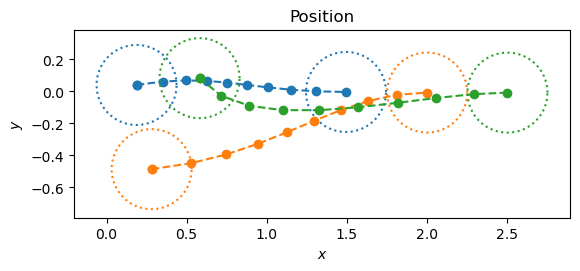

In [ ]:
x_players = np.split(X, M)

# safety radius
th = np.linspace(0, 2 * np.pi, 180)
c_cos = np.cos(th) * r
c_sin = np.sin(th) * r

# plot
plt.figure()
for i, x in enumerate(x_players):
    x1 = x[n:2*n]
    x = np.reshape(x, (n, N), order="F")
    x0 = np.reshape(list_x0[i], (n, 1))
    x = np.hstack((x0, x))
    
    plt.plot(x[0, :], x[1, :], "o--")

    # plot cola radius
    plt.plot(x[0, 0] + c_cos, x[1, 0] + c_sin, ":", c=f"C{i}")
    plt.plot(x[0, -1] + c_cos, x[1, -1] + c_sin, ":", c=f"C{i}")
plt.gca().set_aspect("equal")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Position");

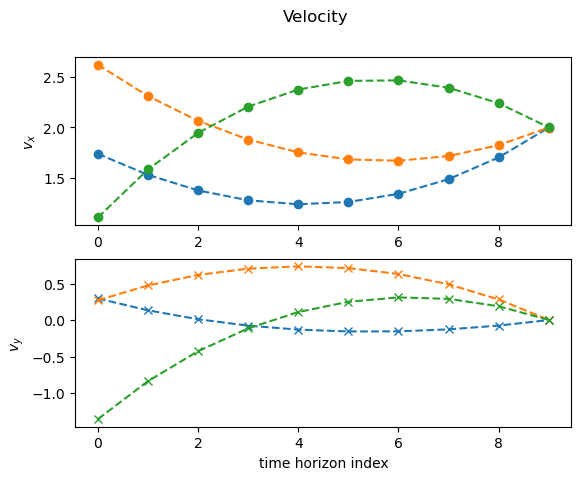

In [19]:
# velocity
plt.figure()
for i, x in enumerate(x_players):
    x = np.reshape(x, (n, N), order="F")
    ax = plt.subplot(211)
    ax.plot(x[2, :], "o--", c=f"C{i}")
    plt.ylabel('$v_x$')
    ax = plt.subplot(212)
    ax.plot(x[3, :], "x--", c=f"C{i}")
    plt.ylabel('$v_y$')
plt.xlabel('time horizon index')
plt.suptitle("Velocity");

Text(0.5, 0.98, 'Control Input')

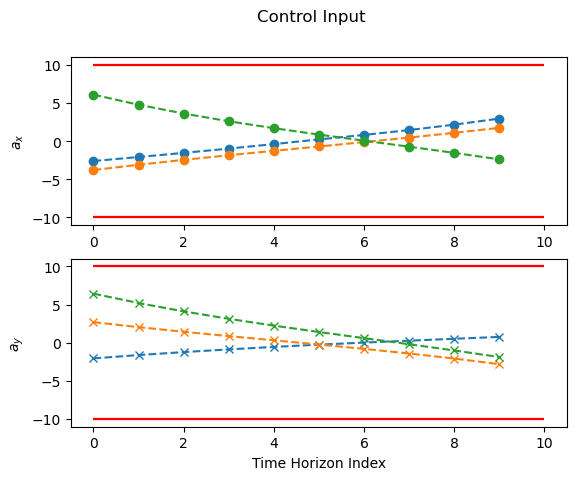

In [55]:
u_players = np.split(U, M)

# plot
plt.figure()
for i, u in enumerate(u_players):
    u = np.reshape(u, (m, N), order="F")
    ax = plt.subplot(211)
    plt.plot(u[0, :], "o--", c=f"C{i}")
    plt.hlines((constraint_u_x_max, -constraint_u_x_max), 0, N, "r")
    plt.ylabel('$a_x$')
    ax = plt.subplot(212)
    plt.plot(u[1, :], "x--", c=f"C{i}")
    plt.hlines((constraint_u_y_max, -constraint_u_y_max), 0, N, "r")
    plt.ylabel('$a_y$')
plt.xlabel('Time Horizon Index')
plt.suptitle("Control Input")

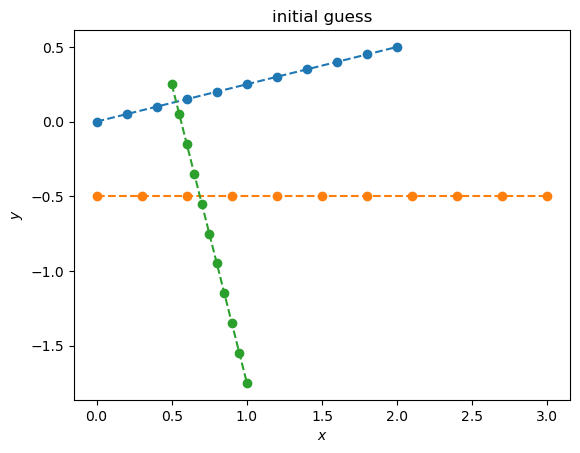

In [21]:
import initial_guess

y0, X_guess, U_guess, mu_guess = initial_guess.generate(list_x0, M, N, n, m, dt)
x_players = np.split(X_guess, M)
plt.figure()
for i, x in enumerate(x_players):
    x = np.reshape(x, (n, N), order="F")
    x0 = np.reshape(list_x0[i], (n, 1))
    x = np.hstack((x0, x))
    plt.plot(x[0, :], x[1, :], "o--")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("initial guess");

0.0019063769032724442


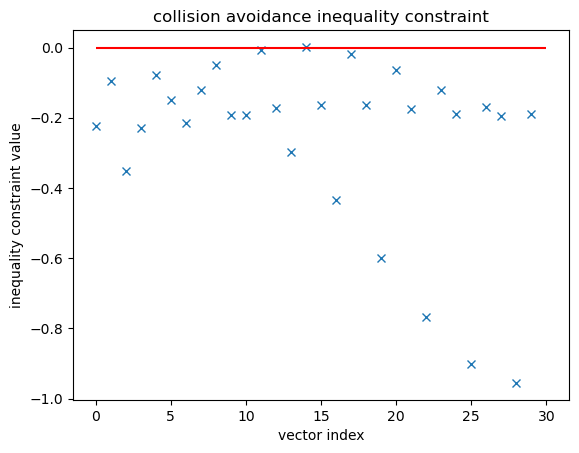

In [22]:
# check collision avoidance
import constraints

cola = constraints.C_cola(X, U, r, constraints.get_system_cola(M, N, n))

plt.figure()
plt.plot(cola, "x")
plt.hlines((0,), 0, N * M, "r")
plt.title("collision avoidance inequality constraint")
plt.xlabel('vector index')
plt.ylabel('inequality constraint value')
print(max(cola))

0.00010741274156134129


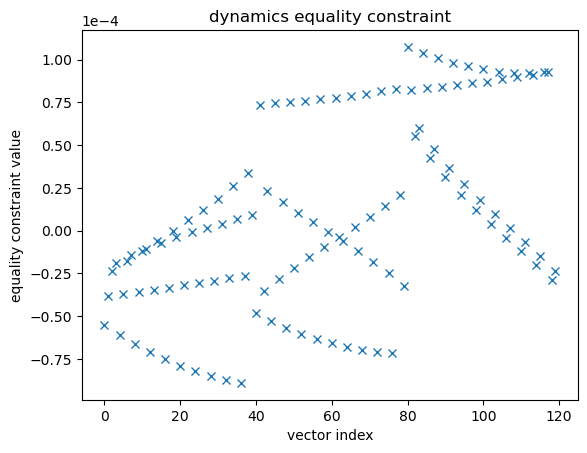

In [23]:
# check dynamics
import dynamics

D = dynamics.D(X, U, *dynamics.get_system_dynamics(M, N, n, m, dt), np.hstack(list_x0))

plt.figure()
plt.plot(D, "x")
plt.title("dynamics equality constraint")
plt.xlabel('vector index')
plt.ylabel('equality constraint value')
plt.ticklabel_format(axis='y', style='sci', scilimits=(3,-3))
print(max(D))